In [29]:
#Created by: Remy Welch
#Date: Jan 20, 2020
#This module is data preparation for a final portfolio project for the Udacity Machine Learning Nanodegree Course
#Overview: The dataset is publically available census data from 1995. The goal will be to predict the income level of an individual using XGBoost

#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score


In [11]:
#Import data. Data has already been split into train/test
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows = 1, header = None) # Make sure to skip a row for the test set

In [12]:
#Check first few rows for any error
#train_set.head()

In [13]:
#add Header Labels
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [14]:
# Replace fields with the ' ?' with NA, then drop them from the dataset
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

In [15]:
#Fix the data issue in the test dataset where the wage_class field has a period at the end
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})


In [16]:
#We need to change the categorical columns into numerical/ordinal inputs for the xgboost model.
#Combine the test and train datasets
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically


In [17]:
#Loop through columns in the combined dataframe and replace strings with an integer
for feature in combined_set.columns:
    if combined_set[feature].dtype == 'object': 
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [18]:
#Now continue with either Predict_income.ipynb or Predict_marital.ipynb

In [19]:
#Split up the dataset back into train and test sets
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

In [20]:
#assign the target variable - wage class
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [23]:
#Now we will make XGboost more efficient using a DMatrix and early stopping rounds
#Create Dmatrix
xgdmat = xgb.DMatrix(final_train, y_train) 

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [24]:
#Assign the final parameters that have been chosen via a Grid Search, optimizing for accuracy
final_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':5} 

#Train the XGBoost model, using early stopping at 433 rounds. 
#The optimal stopping rounds was determined by creating a Dmatrix and running another CV, this time setting an aggresive number of max rounds at 3000
final_gb = xgb.train(final_params, xgdmat, num_boost_round = 433)

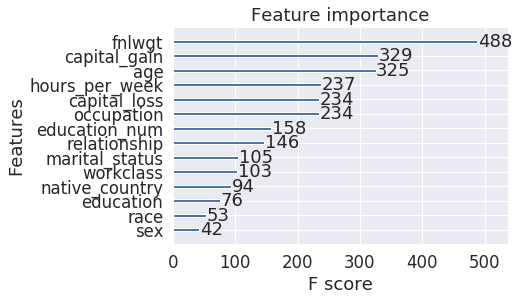

In [25]:
#Look at Feature importance
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)
xgb.plot_importance(final_gb)

In [26]:
#now test the model on our test data to see if it holds up. First create a Dmatrix for the test set
testdmat = xgb.DMatrix(final_test)
#Get the accuracy using sklearn's metrics
y_pred = final_gb.predict(testdmat) 

In [27]:
#Round up/down to 0 (below 5k) or 1 (above 50k)
threshold = 0.5
y_pred[y_pred > threshold] = 1
y_pred[y_pred <= threshold] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

In [30]:
#Get final accuracy
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8678618857901726, 0.13213811420982735)